In [1]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel('baseline_database_codes_RA_group3.xlsx')  # Load Excel file

# Select columns from 'carni_rosse' to 'margarina' and 'DAS28'
columns_to_select = df.loc[:, 'carni_rosse':'margarina'].columns.tolist()
columns_to_select.append('DAS28')
# Add columns ETA_VISITA  SESSO  BMI  DURATA_MALATTIA  Fattore_reumatoide  STEROIDI  bDMARDs  Fumatore
confounders = ['ETA_VISITA', 'SESSO', 'BMI', 'DURATA_MALATTIA', 'Fattore_reumatoide', 'STEROIDI', 'bDMARDs', 'Fumatore']
columns_to_select.extend(confounders)
# exclude 'acqua' and salt/sugar/oil columns
columns_to_exclude = ['acqua', 'sale_cottura', 'sale_dopo_cottura', 'zucchero_aggiunto', 'dolcificante', 'olio_oliva', 'olio_semi']

for col in columns_to_exclude:
    if col in columns_to_select:
        columns_to_select.remove(col)

# Create new database with selected columns
new_database = df[columns_to_select].copy()

expl why i included them as confounders:
ETA_VISITA (Age):
Age influences both dietary habits and RA severity. Older patients may have different diets and disease progression, so age can confound the relationship between diet and RA activity.

SESSO (Sex):
RA prevalence and immune responses differ by sex, and men and women often have different dietary patterns. Controlling for sex avoids biased associations.

BMI:
Body mass index is linked to systemic inflammation and may affect RA activity. It also relates to diet quality and quantity, making it a key confounder.

DURATA_MALATTIA (Disease duration):
How long someone has had RA impacts disease activity and potentially dietary adjustments over time. Longer disease duration may confound observed effects.

Fattore_reumatoide (Rheumatoid factor status):
Presence of RF is associated with more severe RA and could influence both disease activity and dietary choices (e.g., anti-inflammatory diets).

STEROIDI (Steroid use):
Steroids affect inflammation and symptoms directly and may change patients’ appetite or metabolism, influencing dietary intake.

bDMARDs (Biologic treatments):
These medications modulate immune response and RA activity strongly. They can also impact patients’ lifestyle or diet, confounding the relationship.

Fumatore (Smoking status):
Smoking is a major risk factor for RA and affects inflammation. It is also associated with different lifestyle and dietary habits.

In [3]:
new_database.head()

,carni_rosse,maiale,fast.food,carni_bianca,carni_processata,merluzzo_sogliola,sgombro_lanzardo,pesce_spada,masculino_alici,tonno,...,margarina,DAS28,ETA_VISITA,SESSO,BMI,DURATA_MALATTIA,Fattore_reumatoide,STEROIDI,bDMARDs,Fumatore
0,2-3/settimana,2/mese,mai,2/mese,2-3/settimana,2/mese,mai,mai,mai,1/mese,...,mai,3.660762,40.59,Maschio,26.312811,7.61,VERO,VERO,VERO,Fumatore
1,2-3/settimana,2/mese,mai,2-3/settimana,1/settimana,2/mese,mai,mai,1/mese,1/settimana,...,mai,1.796643,37.38,Femmina,21.551020,11.64,FALSO,FALSO,FALSO,Non fumatore
2,2-3/settimana,2-3/settimana,mai,2-3/settimana,1/mese,2/mese,mai,2/mese,2-3/settimana,4-5/settimana,...,2/mese,2.465101,40.36,Femmina,20.069204,8.61,VERO,FALSO,FALSO,Non fumatore
3,2-3/settimana,mai,mai,2-3/settimana,2-3/settimana,1/settimana,mai,1/mese,mai,2/mese,...,mai,3.133907,50.41,Femmina,25.099502,29.62,FALSO,VERO,FALSO,Ex-fumatore
4,1/settimana,mai,mai,2/mese,1/mese,mai,2/mese,1/mese,1/mese,2/mese,...,mai,2.794231,67.70,Femmina,30.859375,13.18,FALSO,FALSO,FALSO,Ex-fumatore


In [4]:
# vero-1, falso-0 for categorical columns (Fattore_reumatoide	STEROIDI	bDMARDs)
categorical_columns = ['Fattore_reumatoide', 'STEROIDI', 'bDMARDs']
for col in categorical_columns:
    new_database[col] = new_database[col].map({'VERO': 1, 'FALSO': 0})

# SESSO column: 0 for 'M', 1 for 'F'
new_database['SESSO'] = new_database['SESSO'].map({'Maschio': 0, 'Femmina': 1})

# Fumatore column:0,1,2 for 'non fumatori', 'ex fumatori', 'fumatori'
new_database['Fumatore'] = new_database['Fumatore'].map({'Non fumatore': 0, 'Ex-fumatore': 1, 'Fumatore': 2})

new_database['DAS28'] = new_database['DAS28'].astype(float)

new_database.head()

,carni_rosse,maiale,fast.food,carni_bianca,carni_processata,merluzzo_sogliola,sgombro_lanzardo,pesce_spada,masculino_alici,tonno,...,margarina,DAS28,ETA_VISITA,SESSO,BMI,DURATA_MALATTIA,Fattore_reumatoide,STEROIDI,bDMARDs,Fumatore
0,2-3/settimana,2/mese,mai,2/mese,2-3/settimana,2/mese,mai,mai,mai,1/mese,...,mai,3.660762,40.59,0,26.312811,7.61,1,1,1,2.0
1,2-3/settimana,2/mese,mai,2-3/settimana,1/settimana,2/mese,mai,mai,1/mese,1/settimana,...,mai,1.796643,37.38,1,21.551020,11.64,0,0,0,0.0
2,2-3/settimana,2-3/settimana,mai,2-3/settimana,1/mese,2/mese,mai,2/mese,2-3/settimana,4-5/settimana,...,2/mese,2.465101,40.36,1,20.069204,8.61,1,0,0,0.0
3,2-3/settimana,mai,mai,2-3/settimana,2-3/settimana,1/settimana,mai,1/mese,mai,2/mese,...,mai,3.133907,50.41,1,25.099502,29.62,0,1,0,1.0
4,1/settimana,mai,mai,2/mese,1/mese,mai,2/mese,1/mese,1/mese,2/mese,...,mai,2.794231,67.70,1,30.859375,13.18,0,0,0,1.0


In [5]:
new_database.shape

(365, 111)

In [6]:
# display columns with missing values and number of missing values
missing_values = new_database.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("Columns with missing values and their counts:")
print(missing_values)

Columns with missing values and their counts:
Fumatore    3
dtype: int64


In [7]:
# drop rows with NaN values
new_database.dropna(inplace=True)

In [8]:
# convert fumatore to int
new_database['Fumatore'] = new_database['Fumatore'].astype(int)

In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [10]:
# Replace "mai" with 0 in the new_database
new_database = new_database.replace("mai", 0)

In [11]:
new_database.head()

,carni_rosse,maiale,fast.food,carni_bianca,carni_processata,merluzzo_sogliola,sgombro_lanzardo,pesce_spada,masculino_alici,tonno,...,margarina,DAS28,ETA_VISITA,SESSO,BMI,DURATA_MALATTIA,Fattore_reumatoide,STEROIDI,bDMARDs,Fumatore
0,2-3/settimana,2/mese,0,2/mese,2-3/settimana,2/mese,0,0,0,1/mese,...,0,3.660762,40.59,0,26.312811,7.61,1,1,1,2
1,2-3/settimana,2/mese,0,2-3/settimana,1/settimana,2/mese,0,0,1/mese,1/settimana,...,0,1.796643,37.38,1,21.551020,11.64,0,0,0,0
2,2-3/settimana,2-3/settimana,0,2-3/settimana,1/mese,2/mese,0,2/mese,2-3/settimana,4-5/settimana,...,2/mese,2.465101,40.36,1,20.069204,8.61,1,0,0,0
3,2-3/settimana,0,0,2-3/settimana,2-3/settimana,1/settimana,0,1/mese,0,2/mese,...,0,3.133907,50.41,1,25.099502,29.62,0,1,0,1
4,1/settimana,0,0,2/mese,1/mese,0,2/mese,1/mese,1/mese,2/mese,...,0,2.794231,67.70,1,30.859375,13.18,0,0,0,1


In [12]:
# Replace frequency values with numeric equivalents
replacement_dict = {
    "1/die": 1,
    "2-3/die": 2.5,
    "4-5/die": 4.5,
    "1/mese": 0.033,
    "2/mese": 0.067,
    "1/settimana": 0.143,
    "2-3/settimana": 0.357,
    "4-5/settimana": 0.643
}

new_database = new_database.replace(replacement_dict).infer_objects(copy=False)

In [13]:
new_database.head()

,carni_rosse,maiale,fast.food,carni_bianca,carni_processata,merluzzo_sogliola,sgombro_lanzardo,pesce_spada,masculino_alici,tonno,...,margarina,DAS28,ETA_VISITA,SESSO,BMI,DURATA_MALATTIA,Fattore_reumatoide,STEROIDI,bDMARDs,Fumatore
0,0.357,0.067,0.0,0.067,0.357,0.067,0.000,0.000,0.000,0.033,...,0.000,3.660762,40.59,0,26.312811,7.61,1,1,1,2
1,0.357,0.067,0.0,0.357,0.143,0.067,0.000,0.000,0.033,0.143,...,0.000,1.796643,37.38,1,21.551020,11.64,0,0,0,0
2,0.357,0.357,0.0,0.357,0.033,0.067,0.000,0.067,0.357,0.643,...,0.067,2.465101,40.36,1,20.069204,8.61,1,0,0,0
3,0.357,0.000,0.0,0.357,0.357,0.143,0.000,0.033,0.000,0.067,...,0.000,3.133907,50.41,1,25.099502,29.62,0,1,0,1
4,0.143,0.000,0.0,0.067,0.033,0.000,0.067,0.033,0.033,0.067,...,0.000,2.794231,67.70,1,30.859375,13.18,0,0,0,1


In [14]:
# Define food categories based on actual column names
food_categories = {
'ultra_processed' : [
    'fast.food', 'patatine_fritte', 'patatine_snack', 'bevande_gassate',
    'dolci_vari', 'gelati_granite', 'creme_spalmabili', 'cornflakes_cereali',
    'spremute_frullati_confezionati', 'tavola_calda', 'cioccolato_latte'
],
'fermented_foods' : [
    'yogurt', 'ricotta_formaggi_magri', 'formaggio.spalmabile'
],
'pro_inflammatory' : [
    'carni_rosse', 'carni_processata', 'maiale', 'fast.food', 'patatine_fritte',
    'burro', 'margarina', 'bevande_gassate', 'dolci_vari', 'gelati_granite', 'cioccolato_latte'
],
'anti_inflammatory' : [
    'sgombro_lanzardo', 'salmone', 'soia_tofu', 'ceci', 'fagioli', 'lenticchie',
    'piselli', 'fave', 'spinaci', 'broccoli', 'zucchine', 'cavoli',
    'pomodori', 'cicoria', 'olive_nere', 'olive_verdi', 'frutti_rossi',
    'arance_rosse', 'kiwi', 'noci', 'mandorle', 'te_verde'
]
}

# Print available columns to help with mapping
columns_list = new_database.columns.tolist()
print("List of columns in new_database:")
print(columns_list)
print(f"\nTotal number of columns: {len(columns_list)}")

List of columns in new_database:
['carni_rosse', 'maiale', 'fast.food', 'carni_bianca', 'carni_processata', 'merluzzo_sogliola', 'sgombro_lanzardo', 'pesce_spada', 'masculino_alici', 'tonno', 'salmone', 'frutti_mare', 'uovo', 'dolci_vari', 'gelati_granite', 'cioccolato_latte', 'cioccolato_fondente', 'patatine_snack', 'castagne', 'arachidi', 'pistacchi', 'noci', 'mandorle', 'nocciole', 'marmellata_miele', 'creme_spalmabili', 'carota', 'spinaci', 'broccoli', 'cavoli', 'cavolfiori', 'piselli', 'fagiolini', 'zucchine', 'cicoria', 'asparagi', 'cipolla', 'aglio', 'funghi', 'insalata', 'pomodori', 'finocchi', 'mais', 'fagioli', 'ceci', 'lenticchie', 'fave', 'carciofi', 'soia_tofu', 'peperoni', 'melanzane', 'olive_verdi', 'olive_nere', 'mele', 'pere', 'arance_mandarini', 'arance_rosse', 'banana', 'uva', 'melone', 'anguria', 'pesche', 'albicocche', 'fragole', 'kiwi', 'ciliegie', 'frutti_rossi', 'melegrano', 'fichi_india', 'prugne', 'fichi', 'te_nero_tisane', 'te_verde', 'te_tisane_frutta', 'caf

In [15]:
# Ensure all values are numeric and fill NaNs with 0
new_database_numeric = new_database.apply(pd.to_numeric, errors='coerce').fillna(0)

# Create a new DataFrame for aggregated values
aggregated_data = pd.DataFrame()

# Loop through the food_categories dictionary to create aggregated columns
for category, cols in food_categories.items():
    aggregated_data[category] = new_database_numeric[cols].sum(axis=1)

# Add the DAS28 column to the aggregated data
aggregated_data['DAS28'] = new_database_numeric['DAS28']
# Add confounders to the aggregated data
for confounder in confounders:
    aggregated_data[confounder] = new_database_numeric[confounder]
# Optional: print resulting columns and preview
print("Aggregated categories:", aggregated_data.columns.tolist())
print(aggregated_data.head())


Aggregated categories: ['ultra_processed', 'fermented_foods', 'pro_inflammatory', 'anti_inflammatory', 'DAS28', 'ETA_VISITA', 'SESSO', 'BMI', 'DURATA_MALATTIA', 'Fattore_reumatoide', 'STEROIDI', 'bDMARDs', 'Fumatore']
   ultra_processed  fermented_foods  pro_inflammatory  anti_inflammatory  \
0            1.090            0.286             1.481              0.565   
1            1.766            0.643             2.310              7.551   
2            1.629            0.357             1.834              2.598   
3            2.209            1.424             1.957              2.866   
4            0.242            0.747             0.418              4.520   

      DAS28  ETA_VISITA  SESSO        BMI  DURATA_MALATTIA  \
0  3.660762       40.59      0  26.312811             7.61   
1  1.796643       37.38      1  21.551020            11.64   
2  2.465101       40.36      1  20.069204             8.61   
3  3.133907       50.41      1  25.099502            29.62   
4  2.794231    

In [16]:
# Calculate the mean of all columns in aggregated_data
column_means = aggregated_data.mean()

print("Mean values for each food category:")
print(column_means)

Mean values for each food category:
ultra_processed        1.652939
fermented_foods        0.654892
pro_inflammatory       1.962909
anti_inflammatory      3.774047
DAS28                  2.472869
ETA_VISITA            57.525028
SESSO                  0.787293
BMI                   24.267457
DURATA_MALATTIA       15.728619
Fattore_reumatoide     0.276243
STEROIDI               0.428177
bDMARDs                0.491713
Fumatore               0.629834
dtype: float64


In [17]:
# # Save aggregated data as a new dataset
# aggregated_data.to_csv('aggregated_food_categories.csv', index=False)

# print("Aggregated data saved successfully as 'aggregated_food_categories.csv'")
# print(f"Dataset contains {aggregated_data.shape[0]} rows and {aggregated_data.shape[1]} columns")
# print(f"Columns saved: {list(aggregated_data.columns)}")

### Check Redundancy via Correlation Matrix

In [18]:
# re_activity and the rest are diet_vars
ra_activity = ['DAS28']
confounders = ['ETA_VISITA', 'SESSO', 'BMI', 'DURATA_MALATTIA', 'Fattore_reumatoide', 'STEROIDI', 'bDMARDs', 'Fumatore']
diet_vars = aggregated_data.columns.difference(ra_activity + confounders).tolist()

Same unit but interested in relative intake patterns, so it's better to standardize, mean = 0, stdev = 1 (negative/positive value means less/more than the average intake)

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_diet = scaler.fit_transform(aggregated_data[diet_vars])

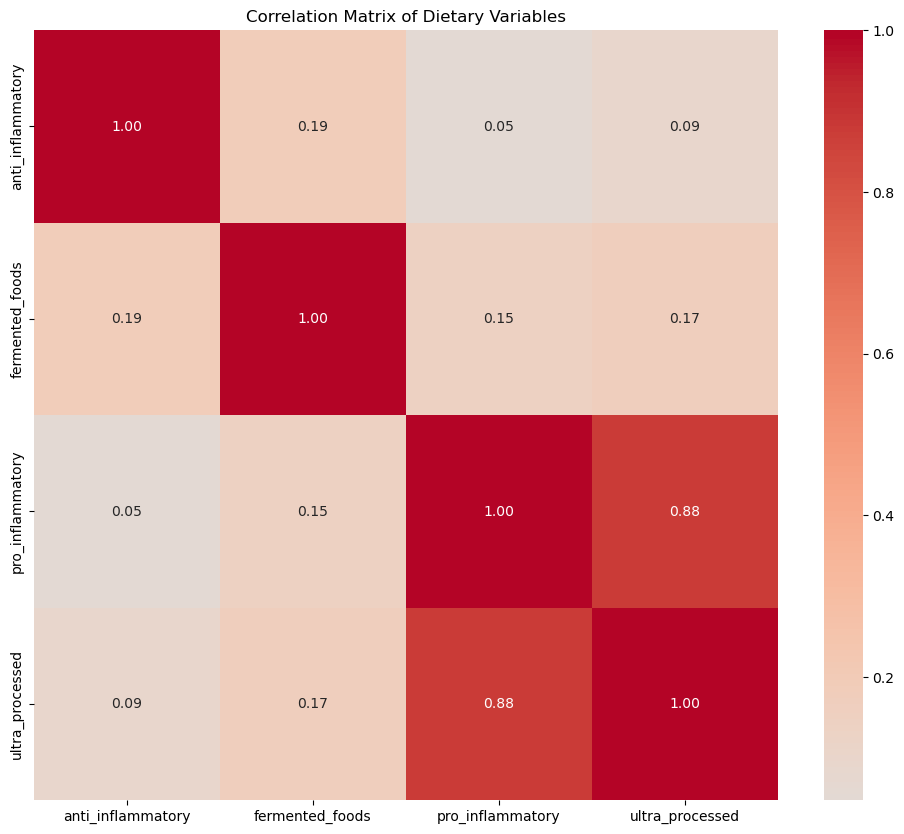

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
corr = aggregated_data[diet_vars].corr()

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Dietary Variables")
plt.show()

## Discovering dietary patterns with Gaussian Mixture Models (GMM)

## Use BIC and AIC 

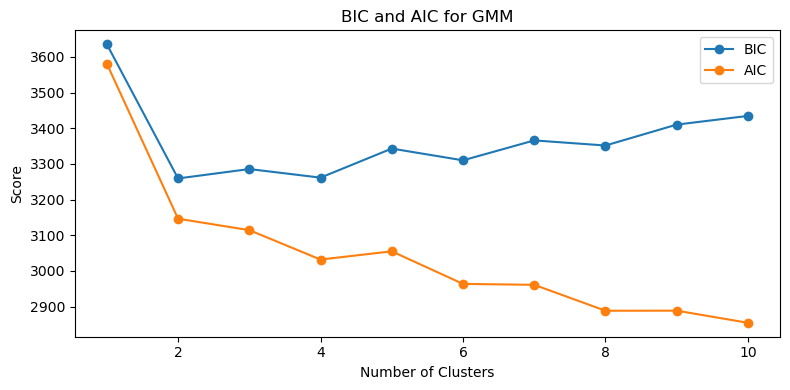

In [21]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

n_components = np.arange(1, 11)  # Try 1 to 10 clusters
bics = []
aics = []

for k in n_components:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_diet)  # Assuming your input data is scaled
    bics.append(gmm.bic(X_diet))
    aics.append(gmm.aic(X_diet))

# Plot BIC and AIC
plt.figure(figsize=(8, 4))
plt.plot(n_components, bics, label='BIC', marker='o')
plt.plot(n_components, aics, label='AIC', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('BIC and AIC for GMM')
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
from sklearn.mixture import GaussianMixture

# Try different numbers of clusters (latent classes)
n_components = 3  # You can try 2, 3, 4, etc. and compare AIC/BIC

gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm.fit(X_diet)

# Get cluster probabilities for each subject
pattern_probs = gmm.predict_proba(X_diet)

# Assign most likely pattern to each subject
pattern_labels = gmm.predict(X_diet)

aggregated_data['diet_pattern'] = pattern_labels


## Explore and visualize the discovered patterns

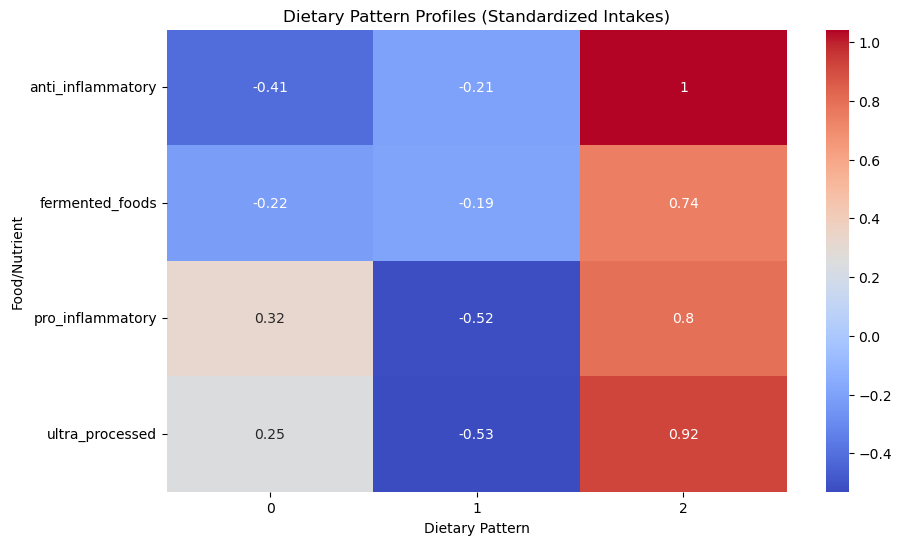

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

pattern_means = pd.DataFrame(gmm.means_, columns=diet_vars)

plt.figure(figsize=(10, 6))
sns.heatmap(pattern_means.T, annot=True, cmap='coolwarm')
plt.title('Dietary Pattern Profiles (Standardized Intakes)')
plt.xlabel('Dietary Pattern')
plt.ylabel('Food/Nutrient')
plt.show()


## just checking ols with identified patterns

### preprocessing confounders

In [24]:
aggregated_data.head()

,ultra_processed,fermented_foods,pro_inflammatory,anti_inflammatory,DAS28,ETA_VISITA,SESSO,BMI,DURATA_MALATTIA,Fattore_reumatoide,STEROIDI,bDMARDs,Fumatore,diet_pattern
0,1.090,0.286,1.481,0.565,3.660762,40.59,0,26.312811,7.61,1,1,1,2,1
1,1.766,0.643,2.310,7.551,1.796643,37.38,1,21.551020,11.64,0,0,0,0,1
2,1.629,0.357,1.834,2.598,2.465101,40.36,1,20.069204,8.61,1,0,0,0,1
3,2.209,1.424,1.957,2.866,3.133907,50.41,1,25.099502,29.62,0,1,0,1,0
4,0.242,0.747,0.418,4.520,2.794231,67.70,1,30.859375,13.18,0,0,0,1,1


In [25]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Dummy encode diet pattern, SESSO, and Fumatore
# df = pd.get_dummies(aggregated_data, columns=['diet_pattern', 'Fumatore'], drop_first=True)


In [26]:
df = aggregated_data.copy()

In [27]:
df.head()

,ultra_processed,fermented_foods,pro_inflammatory,anti_inflammatory,DAS28,ETA_VISITA,SESSO,BMI,DURATA_MALATTIA,Fattore_reumatoide,STEROIDI,bDMARDs,Fumatore,diet_pattern
0,1.090,0.286,1.481,0.565,3.660762,40.59,0,26.312811,7.61,1,1,1,2,1
1,1.766,0.643,2.310,7.551,1.796643,37.38,1,21.551020,11.64,0,0,0,0,1
2,1.629,0.357,1.834,2.598,2.465101,40.36,1,20.069204,8.61,1,0,0,0,1
3,2.209,1.424,1.957,2.866,3.133907,50.41,1,25.099502,29.62,0,1,0,1,0
4,0.242,0.747,0.418,4.520,2.794231,67.70,1,30.859375,13.18,0,0,0,1,1


In [28]:

# Define diet pattern columns (assume 3 total)
# n_components = 3
# diet_vars = [f'diet_pattern_{i}' for i in range(1, n_components)]



df['diet_pattern'] = df['diet_pattern'].astype('category')

# Define confounders after encoding
confounders = [
    'BMI',
    'ETA_VISITA',
    'DURATA_MALATTIA',
    'Fattore_reumatoide',
    'STEROIDI',
    'bDMARDs',
    'SESSO',
    'Fumatore'
]

formula = 'DAS28 ~ C(diet_pattern) + ' + ' + '.join(confounders)
model = smf.ols(formula=formula, data=df).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  DAS28   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     5.143
Date:                Tue, 27 May 2025   Prob (F-statistic):           4.96e-07
Time:                        12:51:59   Log-Likelihood:                -528.32
No. Observations:                 362   AIC:                             1079.
Df Residuals:                     351   BIC:                             1121.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.3984 